In [ ]:
#zip uzantili dosyanin acilmasi
!unzip /content/tissue-dataset.zip

In [ ]:
#veri setinin degisken olarak tanimlanlasi
kesit_resimleri='/content/newkesit'

In [ ]:
# Resimleri modeli egitmeden once on isleme yapilmasi icin gereklilik
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# rescaling
egitim_resim = ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2 , rescale = 1./255 , horizontal_flip=True)
# dogrulama asamasi icin resmin orijinal hali
dogrulama_resim = ImageDataGenerator(rescale = 1./255)

In [ ]:
# egitim seti fotograflarinin dizine akisi, batch size 8 in kati
egitim_seti = egitim_resim.flow_from_directory(kesit_resimleri, target_size=(224,224), batch_size=16)
# dogrulama seti seti fotograflarinin dizine akisi, batch size 8 in kati
dogrulama_seti = dogrulama_resim.flow_from_directory(kesit_resimleri, target_size=(224,224), batch_size=16)

egitim_seti.class_indices
dogrulama_seti.class_indices

Found 80 images belonging to 10 classes.
Found 80 images belonging to 10 classes.


{'cerebellum': 0,
 'dil': 1,
 'gobekbagi': 2,
 'hyalinkikirdak': 3,
 'kemik': 4,
 'lingualis': 5,
 'mandibularis': 6,
 'mide': 7,
 'trakebagdoku': 8,
 'trakesillisilindirikepitel': 9}

In [ ]:
egitimclasslari=egitim_seti.class_indices

# Tahmin icin icin sonuclarinlarin kayidi
Sonuc={}
for i,k in zip(egitimclasslari.values(),egitimclasslari.keys()):
    Sonuc[i]=k
# Sonuc Dosyasinin kaydi
import pickle
with open("Sonuc.pkl", 'wb') as fileWriteStream:
    pickle.dump(Sonuc, fileWriteStream)

print("Dokularin Classlari ve Isimleri ve ",Sonuc)

Toplam=len(Sonuc)
print('\n Toplam ornek sayisi: ', Toplam)

Dokularin Classlari ve Isimleri ve  {0: 'cerebellum', 1: 'dil', 2: 'gobekbagi', 3: 'hyalinkikirdak', 4: 'kemik', 5: 'lingualis', 6: 'mandibularis', 7: 'mide', 8: 'trakebagdoku', 9: 'trakesillisilindirikepitel'}

 Toplam ornek sayisi:  10


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import shutil
import math
import imutils

In [ ]:
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.preprocessing import image
import keras

In [ ]:
# mobile net tanimlanmasi
base_mobilenet = MobileNet(input_shape=(224,224,3),include_top=False, weights="imagenet")

# ekstra katmanlarin eklenmesi
adddional_layer = Flatten()(base_mobilenet.output) # verilerin sinir agina hazirlanmasi
adddional_layer = (Dense(Toplam, activation='softmax'))(adddional_layer) # vektorlerin boyutlarin artirilmasi ekstra feature icin

# kendi modelimiz
mobilenet_model = Model(base_mobilenet.input, adddional_layer)
mobilenet_model.summary()
mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']  )

17225924/17225924 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128    

In [ ]:
from keras.callbacks import ModelCheckpoint

# her asamada en iyi modeli kayit etme
mc = ModelCheckpoint(filepath="mobilenet_best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# liste olarak kayit
call_back = [mc]

In [ ]:
import time
# Gecen surenin hesabi
StartTime=time.time()

# modelin egitimi

hist = mobilenet_model.fit(egitim_seti, # egitim icin kullanilacak veri seti
                           steps_per_epoch= 5, # her epoch adim sayisi
                           epochs= 50, # epoch sayisi
                           validation_data= dogrulama_seti, # dogrulama icin kullanilacak veri seti
                           validation_steps= 5, # her dogrulama adim sayisi
                           callbacks=[mc]) # en iyi modelin kontrolu

EndTime=time.time()
print("Gecen sure: ", round((EndTime-StartTime)/60), 'Dakika')

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 3.1126 - accuracy: 0.3000
Epoch 1: val_accuracy improved from -inf to 0.27500, saving model to mobilenet_best_model.h5
5/5 [==============================] - 36s 730ms/step - loss: 3.1126 - accuracy: 0.3000 - val_loss: 6.3289 - val_accuracy: 0.2750
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 1.0674 - accuracy: 0.6500
Epoch 2: val_accuracy improved from 0.27500 to 0.55000, saving model to mobilenet_best_model.h5
5/5 [==============================] - 2s 422ms/step - loss: 1.0674 - accuracy: 0.6500 - val_loss: 4.9033 - val_accuracy: 0.5500
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 0.1760 - accuracy: 0.9250
Epoch 3: val_accuracy improved from 0.55000 to 0.61250, saving model to mobilenet_best_model.h5
5/5 [==============================] - 2s 433ms/step - loss: 0.1760 - accuracy: 0.9250 - val_loss: 4.7793 - val_accuracy: 0.6125
Epoch 4/50
5/5 [==============================] - E

In [ ]:
# en iyi modelin yuklenmesi
from keras.models import load_model
mobilenet_model = load_model("/content/mobilenet_best_model.h5")

<ipython-input-14-d8fb05c8ea9c>:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = mobilenet_model.evaluate_generator(generator= dogrulama_seti)[1]


Modelin Doğruluğu = 92.5000011920929 %


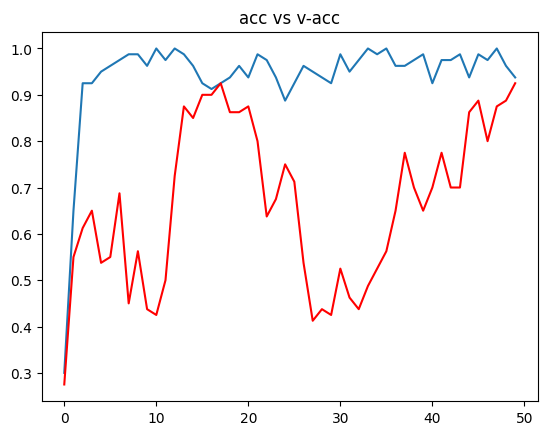

In [ ]:
h =  hist.history
h.keys()

# en iyi modelin dogrulugu
acc = mobilenet_model.evaluate_generator(generator= dogrulama_seti)[1]

print(f"Modelin Doğruluğu = {acc*100} %")

# egitim asamasi dogruluk kiyaslamasi
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

In [ ]:
from keras.utils import load_img
from keras.utils import img_to_array

Doku:  kemik


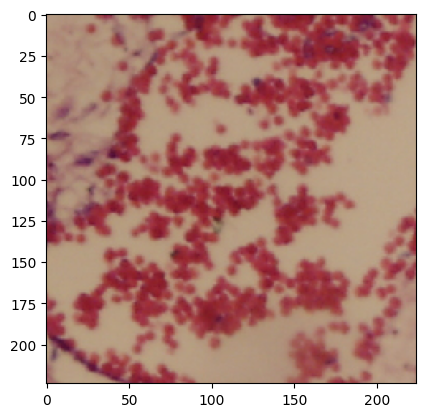

In [ ]:
#Test Uygulamasi

ImagePath='/content/Test/kemik/kemik10.jpg'


test_image=load_img(ImagePath,target_size=(224, 224))
test_image=img_to_array(test_image)
test_image = test_image / 255. #yeniden olceklendirme(rescale)


test_image=np.expand_dims(test_image,axis=0)

resultd=mobilenet_model.predict(test_image,verbose=0)


print('Doku: ',Sonuc[np.argmax(resultd)])

plt.imshow(test_image[0])
plt.show()